In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

<module 'libs.models' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,atr_ratio,atr_ratio_sma,vol_15,bb_width_20,r_5,r_15,rsi,stoch_d_3,stoch_k_14,hour,eng_adx,eng_obv,eng_ma,bid,ask,signal
2004-01-02 13:07:00,-0.996380,-0.987015,-1.005076,-0.943230,-0.014129,-0.009476,-2.476841,-1.585648,-1.552562,0.507,-0.027995,-0.021099,-0.001209,0.763698,0.764840,0.258111
2004-01-02 13:08:00,-0.994579,-0.986828,-1.001603,-0.937271,-0.027502,-0.017401,-2.476841,-1.585648,-1.552562,0.507,-0.027995,-0.029567,-0.001209,0.763681,0.764824,0.266279
2004-01-02 13:09:00,-0.992906,-0.986557,-0.999187,-0.930276,-0.040876,-0.025327,-2.476841,-1.585648,-1.552562,0.507,-0.027995,-0.039000,-0.001209,0.763664,0.764807,0.274718
2004-01-02 13:10:00,-0.991353,-0.986209,-0.997370,-0.922523,-0.054250,-0.033253,-2.476841,-1.585648,-1.552562,0.507,-0.027995,-0.049325,-0.001209,0.763647,0.764790,0.283435
2004-01-02 13:11:00,-0.989911,-0.985789,-0.995973,-0.914218,-0.067624,-0.041178,-2.476841,-1.585648,-1.552562,0.507,-0.027995,-0.060465,-0.001209,0.763631,0.764773,0.292439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.582507,0.182057,0.348747,0.119570,1.736669,1.315228,0.811095,0.172658,0.354296,-0.941,0.348383,0.234328,12.115664,196.667400,196.962600,0.546641
2025-06-18 20:57:00,0.641713,0.207647,0.391507,0.184714,0.884588,1.113128,0.539711,0.332103,0.426843,-0.941,0.447111,0.120971,12.401440,196.527500,196.822500,0.529260
2025-06-18 20:58:00,0.574130,0.230765,0.392142,0.238300,0.340813,0.827243,0.530165,0.396310,0.381683,-0.941,0.538824,0.000337,12.401440,196.522500,196.817500,0.506342
2025-06-18 20:59:00,0.695123,0.261866,0.692251,0.242399,-0.840175,-0.093724,-0.151391,0.213673,-0.182061,-0.941,0.236622,-0.445174,9.257911,196.092800,196.387200,0.490520


In [4]:
# Build LSTM input tensors (disk-backed memmaps)
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape, "(samples,)")
print("  y_ret     =", y_ret.shape, "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Inside build_lstm_tensors, using: ['atr_ratio', 'atr_ratio_sma', 'vol_15', 'bb_width_20', 'r_5', 'r_15', 'rsi', 'stoch_d_3', 'stoch_k_14', 'hour', 'eng_adx', 'eng_obv', 'eng_ma']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2414427, 60, 13]) (samples, look_back, features)
  y_sig     = torch.Size([2414427]) (samples,)
  y_ret     = torch.Size([2414427]) (samples,)
  raw_close = torch.Size([2414427])
  raw_bid   = torch.Size([2414427])
  raw_ask   = torch.Size([2414427])
  end_times = (2414427,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1696435, 60, 13])
  y_sig_tr, y_ret_tr = torch.Size([1696435]) torch.Size([1696435])
  X_val = torch.Size([353133, 60, 13])
  y_sig_val, y_ret_val = torch.Size([353133]) torch.Size([353133])
  X_te  = torch.Size([364859, 60, 13])
  y_sig_te, y_ret_te = torch.Size([364859]) torch.Size([364859])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days  → train=3808, val=783, test=809
Batches → train=119,   val=783,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = X.shape[-1],                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(params.device)  

model

DualMemoryLSTM(
  (conv): Conv1d(13, 13, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(13, 48, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.25, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.3, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
)

In [8]:
# # -----------------------------------------------------------------------------
# # Compute plateau_sched timing parameters
# # -----------------------------------------------------------------------------
# # Total training samples = total windows in X_tr (one window per row)
# n_train_samples = X_tr.shape[0]

# # How many optimizer steps (day‐bundles) constitute one epoch?
# steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0002
    lr: 0.0002
    maximize: False
    weight_decay: 0.0005
)

In [9]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.431005,  val = 0.437625

Train target stats:
  mean = 0.3138,  var = 0.0873,  std = 0.2954
Train mean‐predictor baseline:
  RMSE_baseline = 0.295440
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.3258,  var = 0.0854,  std = 0.2922
Validation mean‐predictor baseline:
  RMSE_baseline = 0.292230
  R²_baseline   = 0.00



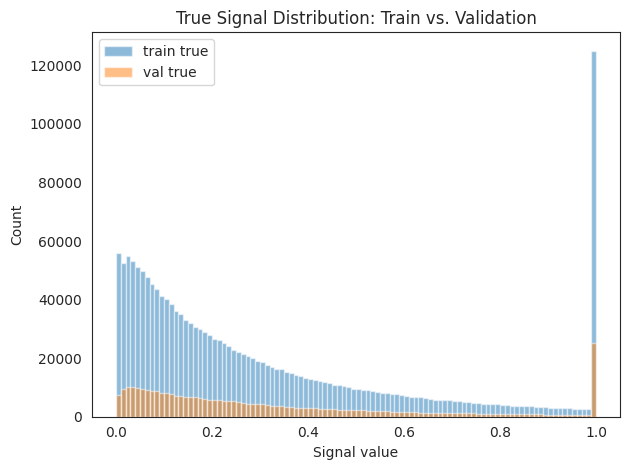

In [10]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3808 unique trading days per epoch.



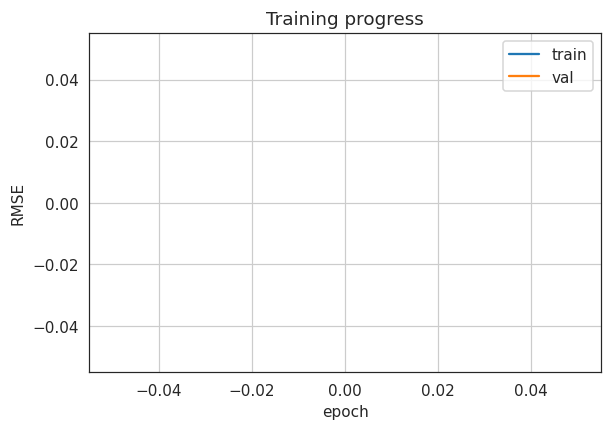

Epoch 1:   0%|          | 0/119 [00:00<?, ?batch/s]

In [ ]:
# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")

